## 神经网络

Autograd实现了反向传播功能，但是直接用来写深度学习的代码在很多情况下还是稍显复杂，torch.nn是专门为神经网络设计的模块化接口。nn构建于 Autograd之上，可用来定义和运行神经网络。nn.Module是nn中最重要的类，可把它看成是一个网络的封装，包含网络各层定义以及forward方法，调用forward(input)方法，可返回前向传播的结果。

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [96]:
# 定义一个网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 仿射层/全连接层，y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
    # 卷积 -> 激活 -> 池化 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

In [97]:
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [98]:
params = net.parameters()  # 网络的可学习参数
params, len(list(params))

(<generator object Module.parameters at 0x00000296A8E67E08>, 10)

In [99]:
for name, parameters in net.named_parameters():   # net.named_parameters可同时返回可学习的参数及名称
    print(name, ':', parameters.size())

conv1.weight : torch.Size([6, 1, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


In [100]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
out.size()

torch.Size([1, 10])

In [101]:
out

tensor([[ 0.0071,  0.0579,  0.0985,  0.0242,  0.0981, -0.0783,  0.0753,
          0.1373, -0.0037, -0.0356]])

###### 损失函数
nn实现了神经网络中大多数的损失函数，例如nn.MSELoss用来计算均方误差，nn.CrossEntropyLoss用来计算交叉熵损失。

In [102]:
output = net(input)
target = torch.arange(0,10).view(1,10) 
criterion = nn.MSELoss()
loss = criterion(output, target)
loss # loss是个scalar

tensor(28.2272)

In [103]:
# 运行.backward，观察调用之前和调用之后的grad
net.zero_grad() # 把net中所有可学习参数的梯度清零
print('反向传播之前 conv1.bias的梯度')
print(net.conv1.bias.grad)
loss.backward()
print('反向传播之后 conv1.bias的梯度')
print(net.conv1.bias.grad)

反向传播之前 conv1.bias的梯度
None
反向传播之后 conv1.bias的梯度
tensor([ 0.0840, -0.1576,  0.0089,  0.0368,  0.0421, -0.0031])


###### 优化器

In [104]:
import torch.optim as optim
#新建一个优化器，指定要调整的参数和学习率
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# 在训练过程中
# 先梯度清零(与net.zero_grad()效果一样)
optimizer.zero_grad() 

# 计算损失
output = net(input)
loss = criterion(output, target)

#反向传播
loss.backward()

#更新参数
optimizer.step()

##### 实战：
CIFAR-10分类

In [105]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [106]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

# 下载数据集，若相应目录存在，通过root参数指定
trainset = torchvision.datasets.CIFAR10(root='../../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


##### Dataset对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。

50000
torch.Size([3, 32, 32])
frog


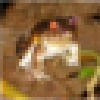

In [107]:
show = ToPILImage() # 可以把Tensor转成Image，方便可视化
(data, label) = trainset[0]   
print(len(trainset))
print(data.size())
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100,100))

In [108]:
# 定义网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1)     # 等价 x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [109]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [110]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outs = net(inputs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()   # loss.data[0]
        if (i+1) % 2000 == 0:
            print('{}, {}, loss: {:.4f}'.format(epoch + 1, i + 1, running_loss/200))
            running_loss = 0.0

1, 2000, loss: 21.7832
1, 4000, loss: 19.0221
1, 6000, loss: 16.9623
1, 8000, loss: 15.9697
1, 10000, loss: 15.1915
1, 12000, loss: 14.5527
2, 2000, loss: 13.6899
2, 4000, loss: 13.7065
2, 6000, loss: 13.3567
2, 8000, loss: 12.8107
2, 10000, loss: 12.7842
2, 12000, loss: 12.6394


实际的label:       cat     ship     ship    plane


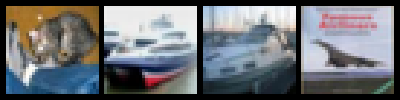

In [111]:

dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(torchvision.utils.make_grid(images / 2 + 0.5)).resize((400,100))

In [112]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = torch.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

预测结果:    cat  ship  ship  ship


In [113]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 57 %


In [114]:
# 查看每个类别的识别率
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# for data in testloader:
#     images, labels = data
#     outputs = net(images)
#     _, predicted = torch.max(outputs.data, 1)
#     c = (predicted == labels).squeeze()
#     for i in range(4):
#         label = labels[i]
#         class_correct[label] += c[i]
#         class_total[label] += 1

# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i].float() / class_total[i]))


Accuracy of plane : 15 %
Accuracy of   car : 16 %
Accuracy of  bird :  2 %
Accuracy of   cat : 25 %
Accuracy of  deer :  0 %
Accuracy of   dog :  2 %
Accuracy of  frog : 19 %
Accuracy of horse : 19 %
Accuracy of  ship :  0 %
Accuracy of truck : 14 %
